# Simple Grid example

Let's take an example of GridWorld where we have $r = -1$ on all the tiles except for $r(\textrm{target}) = 10$.

Actions are `north`, `south`, `east`, `west`

In [1]:
import gymnasium as gym 
from mdp import environments
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import defaultdict
import pandas as pd 
import numpy as np 
import torch 

**Example**: We want to check for VFA convergence with different targets and feature design

In [2]:
env = gym.make('SimpleGrid-v0', size=16, target=(0, 0))

In [3]:
state, _ = env.reset()
for i in range(6):
    action = env.action_space.sample()
    before_moving = env.unwrapped._agent_location
    s_prime, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print(f"Agent in {before_moving} go to {env.unwrapped.action_name(action)} ending in {env.unwrapped._agent_location}")
        print("END OF EPISODE")
        state, _ = env.reset()
    else:
        print(f"Agent in {before_moving} go to {env.unwrapped.action_name(action)} ending in {s_prime}")
        state = s_prime

Agent in [2 3] go to E ending in [3 3]
Agent in [3 3] go to E ending in [3 3]
Agent in [3 3] go to S ending in [3 2]
Agent in [3 2] go to W ending in [2 2]
Agent in [2 2] go to E ending in [3 2]
Agent in [3 2] go to W ending in [2 2]


### Create an agent
The agent will describe a state in the Grid as $\mathbf{x}(s) = \left[1, x, y\right]$

In [4]:
from mdp.agents import AgentVFA

In [5]:
class GridAgent(AgentVFA):
    def x(self, state):
        features = np.array([1, state[0], state[1]])
        return torch.tensor(features, dtype=float, requires_grad=False)

In [6]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make('SimpleGrid-v0', size=64, target=(0, 0))
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = GridAgent(
    n_features=3, environment=env, learning_rate=learning_rate, epsilon=start_epsilon, 
    epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=1
) # non discounted episodes

In [7]:
state, _ = env.reset()
v_hat = agent.v(state)
print(f"State {state}, features {agent.x(state).detach().numpy()}, parameters {agent.w.detach().numpy()}, V(state) = {v_hat.detach().numpy()}")

State [6 2], features [1. 6. 2.], parameters [1. 1. 1.], V(state) = 9.0


**Training**

In [8]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [9]:
agent.td_learning(max_iterations = 50_000)

100%|██████████| 50000/50000 [00:10<00:00, 4932.49it/s]


In [10]:
agent.w 

tensor([-22.9497, -10.6396,  -3.0704], dtype=torch.float64, requires_grad=True)

In [11]:
w = 300
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(agent.training_error).flatten(), win=w)

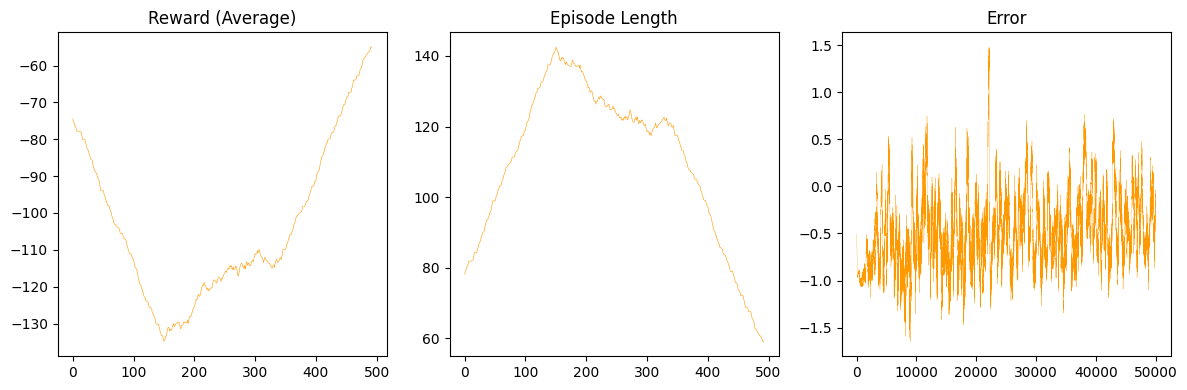

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

**State values**

In [13]:
grid = np.zeros(env.unwrapped.size).reshape(env.unwrapped.row, -1)
for x in range(grid.shape[0]):
    for y in range(grid.shape[1]):
        grid[np.abs(x - (grid.shape[0]-1)), y] = agent.v(np.array([x, y])).item()

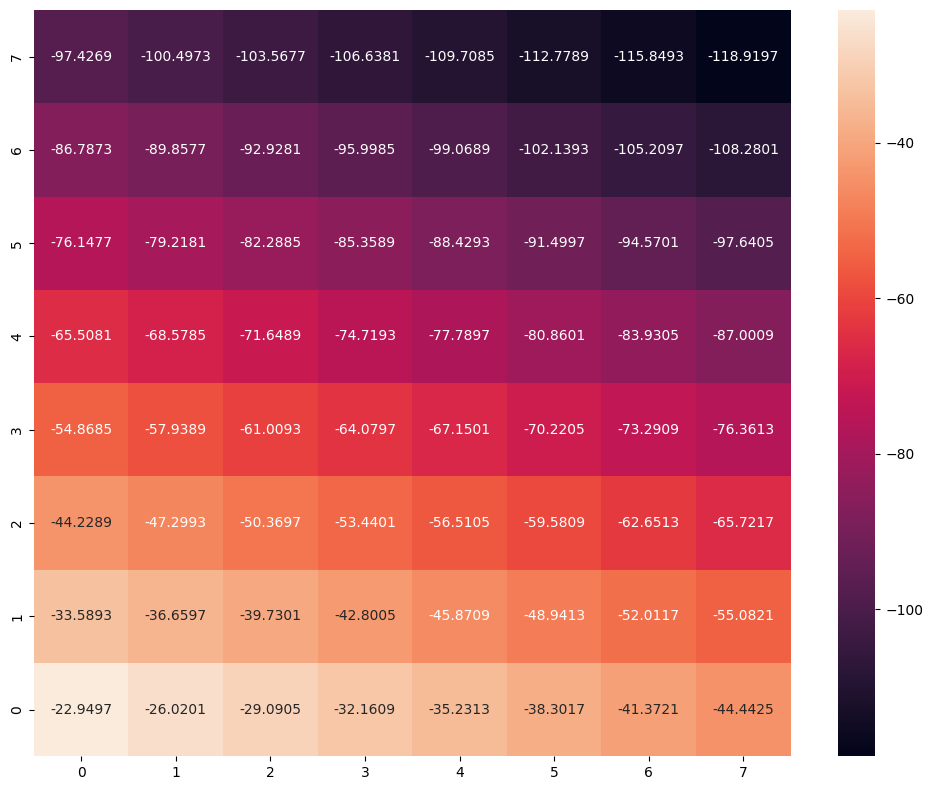

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(grid, annot=True, fmt=".4f", ax=ax)
ax.set_yticklabels(reversed(range(grid.shape[1])))
plt.tight_layout()
plt.show()

**Change the target tile**

In [15]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make('SimpleGrid-v0', size=64, target=(12, 12))
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = GridAgent(
    n_features=3, environment=env, learning_rate=learning_rate, epsilon=start_epsilon, 
    epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=1
) # non discounted episodes

In [16]:
agent.td_learning(max_iterations = 50_000)

100%|██████████| 50000/50000 [00:09<00:00, 5162.01it/s]


In [17]:
w = 300
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(agent.training_error).flatten(), win=w)

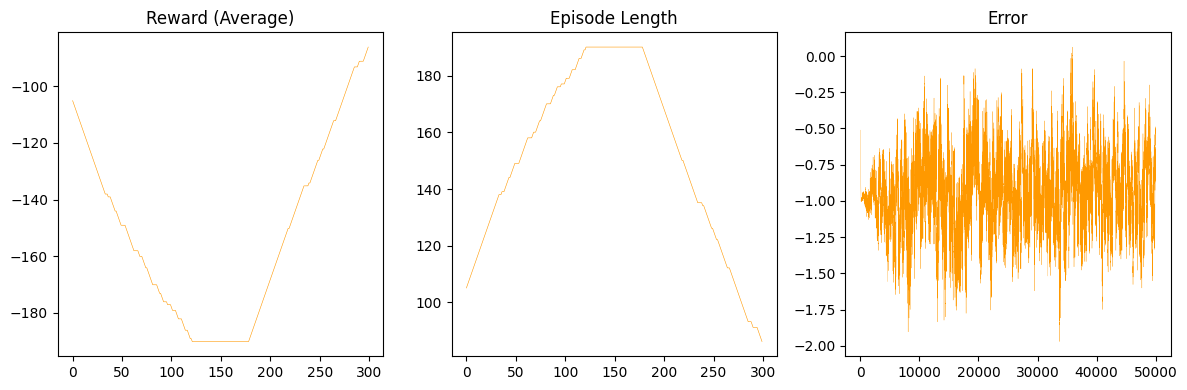

In [18]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

In [19]:
grid = np.zeros(env.unwrapped.size).reshape(env.unwrapped.row, -1)
for x in range(grid.shape[0]):
    for y in range(grid.shape[1]):
        grid[np.abs(x - (grid.shape[0]-1)), y] = agent.v(np.array([x, y])).item()

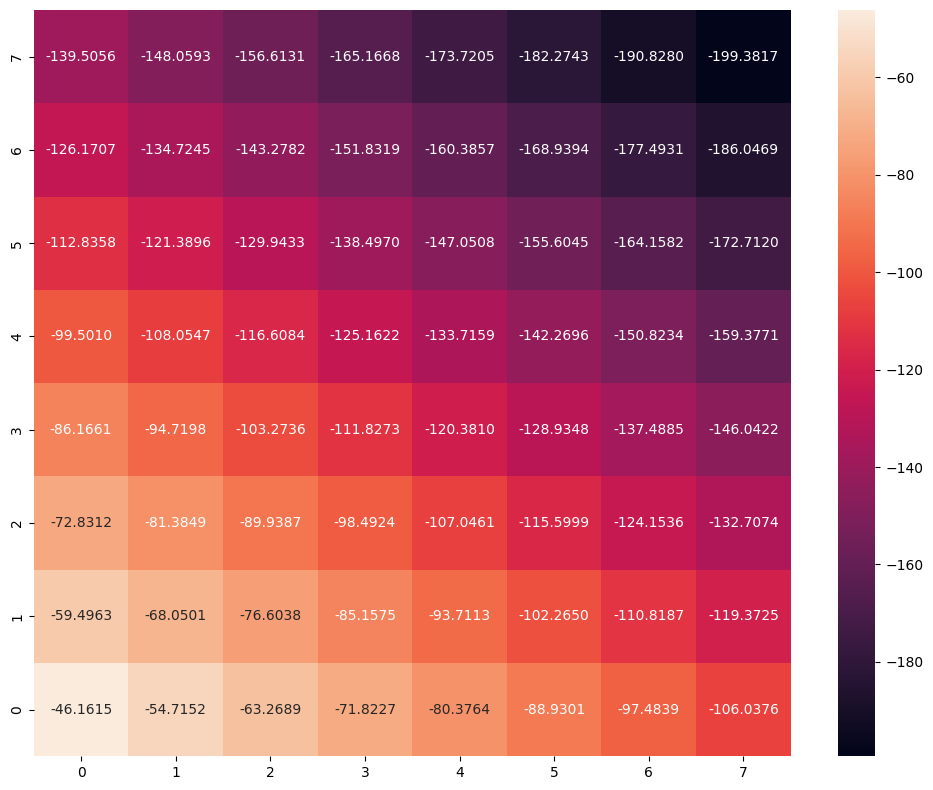

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(grid, annot=True, fmt=".4f", ax=ax)
ax.set_yticklabels(reversed(range(grid.shape[1])))
plt.tight_layout()
plt.show()

In [21]:
agent.w

tensor([-46.1615, -13.3349,  -8.5537], dtype=torch.float64, requires_grad=True)